# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
y_test_orig = y_test.copy()

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test =  X_test.shape[0]

# TODO: what's the shape of an image?
image_shape =  X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


examples for classes


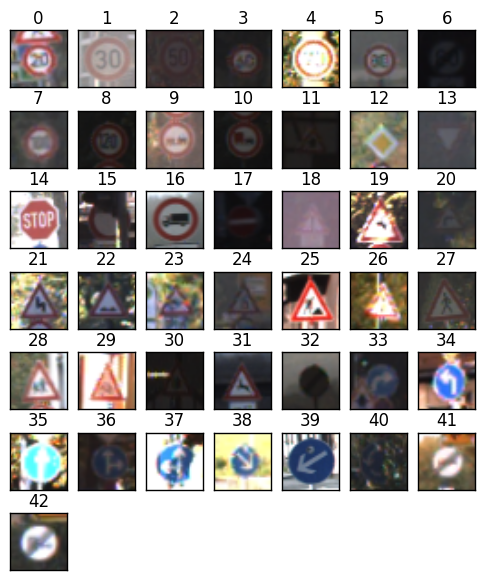

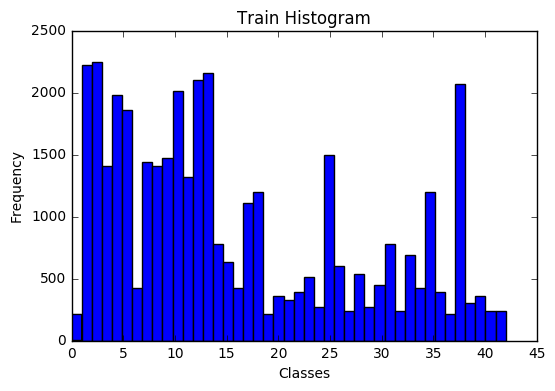

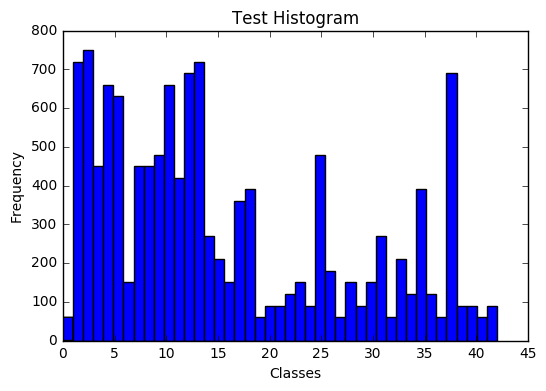

In [3]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
%matplotlib inline

#show one image for each class
row = 0
col = 0
fig = plt.figure()
print("examples for classes")
gs = gridspec.GridSpec(7, 7)
fig.subplots_adjust(top=1.5)
for i in range(n_classes):
  query = np.where(y_train == i)
  a = plt.subplot(gs[row, col])
  a.imshow((X_train[query])[0])
  a.get_xaxis().set_visible(False)
  a.get_yaxis().set_visible(False)
  fig.add_subplot(a)
  a.set_title(i)
  col += 1                   
  if col == 7:
    col = 0
    row += 1
plt.show()
                     
#show histogram for train and test classes
fig = plt.figure()
plt.hist(y_train,n_classes)
plt.title("Train Histogram")
plt.xlabel("Classes")
plt.ylabel("Frequency")

fig = plt.figure()
plt.hist(y_test,n_classes)
plt.title("Test Histogram")
plt.xlabel("Classes")
plt.ylabel("Frequency")



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

X_train: (39209, 32, 32, 3)
X_train_g: (39209, 32, 32)
X_test: (12630, 32, 32, 3)
X_test_g: (12630, 32, 32)


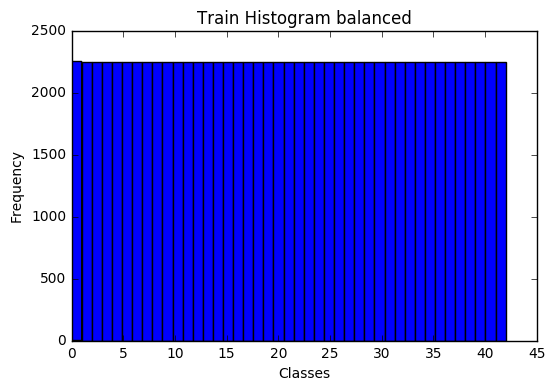

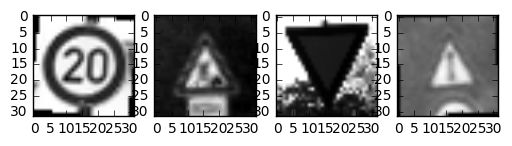

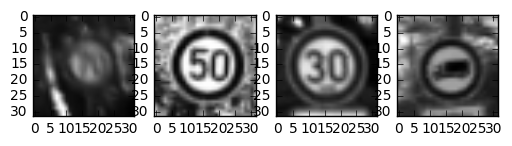

mean: -0.379661  min: -1.0  max: 1.0


In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2
from sklearn.preprocessing import LabelBinarizer
import scipy.ndimage

#get the grayscale image
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

X_train_g = []
X_test_g = []
#convert train and test to gray
for i in range(n_train):
    X_train_g.append(grayscale(X_train[i]))

for i in range(n_test):
    X_test_g.append(grayscale(X_test[i]))
 
X_train_g = np.array(X_train_g)
X_test_g = np.array(X_test_g)

#show the shape of the data
print("X_train:",X_train.shape)
print("X_train_g:",X_train_g.shape)
print("X_test:",X_test.shape)
print("X_test_g:",X_test_g.shape)

#balance train set by addng rotated and shifted images
n_per_class = np.bincount(y_train)
max_per_class = int(np.max(n_per_class))

for i in range(n_classes):
  n_add = max_per_class -  n_per_class[i]

  if n_add <= 0:
    continue

  query = np.where(y_train == i)

  angles = np.random.uniform(-10, 10, size=n_add)    
#  print(n_per_class[i],"/",max_per_class," add ",n_add, " for class", i)
  ai = 0
  X_train_add = []
  y_train_add = []
  while len(X_train_add) < n_add:
    for x in X_train_g[query]:
      X_train_add.append(scipy.ndimage.rotate(x, angles[ai], reshape=False))
      y_train_add.append(i)
      ai +=1
      if len(X_train_add) == n_add:
        break;
    
  X_train_g = np.append(X_train_g,X_train_add, axis=0)
  y_train = np.append(y_train,y_train_add, axis=0)

n_train = X_train_g.shape[0]

fig = plt.figure()
plt.hist(y_train,n_classes)
plt.title("Train Histogram balanced")
plt.xlabel("Classes")
plt.ylabel("Frequency")

#shuffle train data randomly
random_indizes = np.arange(n_train)
np.random.shuffle(random_indizes)

#show gray images for some train cases
fig = plt.figure()
for i in range(4):
  a=fig.add_subplot(1,4,i+1)
  plt.imshow(X_train_g[random_indizes[i]],cmap="gray")
plt.show()

#shuffle test data randomly
random_indizes = np.arange(n_test)
np.random.seed(1)
np.random.shuffle(random_indizes)

#show gray images for some test cases
fig = plt.figure()
for i in range(4):
  a=fig.add_subplot(1,4,i+1)
  plt.imshow(X_test_g[random_indizes[i]], cmap="gray")
plt.show()

#normalize the images
X_train_g = X_train_g.astype('float32')
X_train_g -= 127.5 
X_train_g /= 127.5 

X_test_g = X_test_g.astype('float32')
X_test_g -= 127.5
X_test_g /= 127.5 

#reshape to rank 4 tensor
X_train_g = np.reshape(X_train_g,(X_train_g.shape[0],X_train_g.shape[1],X_train_g.shape[2],1))
X_test_g = np.reshape(X_test_g,(X_test_g.shape[0],X_test_g.shape[1],X_test_g.shape[2],1))

#some statictics mean min, max
print("mean:",np.mean(X_train_g )," min:",np.min(X_train_g )," max:",np.max(X_train_g ))

# Turn labels into numbers and apply One-Hot Encoding
# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train).astype(np.float32)
y_test = encoder.transform(y_test).astype(np.float32)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:** 
1. I converted the train and test images to gray scale 
2. the input data has been normalized to values between -1 and 1
3. the class indizes are encoded to a vector of byte values
4. the input data needed to be reshaped to have 4 dimensions and converted to float32
5. I balanced the distribution of classes on the trainset by adding rotated images between -10 and 10 degrees 

In [5]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

#shuffle the data randomly
random_indizes = np.arange(n_train)
np.random.seed(1)
np.random.shuffle(random_indizes)

#split the data in a train and validation set
max_train_index = int(n_train*4/5)
max_index = len(random_indizes)-1
    
X_train_g1 = X_train_g[random_indizes[0:max_train_index],]
X_valid_g1 = X_train_g[random_indizes[(max_train_index+1):max_index],]

y_train_1 = y_train[random_indizes[0:max_train_index],]
y_valid_1 = y_train[random_indizes[(max_train_index+1):max_index],]

#show the shapes for verification
print("X_train_g1:",X_train_g1.shape)
print("y_train_1:",y_train_1.shape)

print("X_valid_g1:",X_valid_g1.shape)
print("y_valid_1:",y_valid_1.shape)

print("X_test_g:",X_test_g.shape)
print("y_test:",y_test.shape)


X_train_g1: (77400, 32, 32, 1)
y_train_1: (77400, 43)
X_valid_g1: (19348, 32, 32, 1)
y_valid_1: (19348, 43)
X_test_g: (12630, 32, 32, 1)
y_test: (12630, 43)


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** 
I splitted the train data set in a 80% train data and 20% valid data and shuffled them randomly.
Training is executed in batches because of the high amount of train data.
After all 50 batches training and validation accuracy is measured.
Testing is done after all epochs are finished.
I added randomly rotated data to the train data to balance the occurence of the classes. This helps to avoid that the training is bad for rare classes.


In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.0, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride, padding='VALID'):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)

images = tf.placeholder(tf.float32, shape=[None, X_train_g1.shape[1], X_train_g1.shape[2],1])
labels = tf.placeholder(tf.float32, shape=[None,y_train_1.shape[1]])
keep_prob = tf.placeholder(tf.float32)

print("images",images.get_shape())
print("labels",labels.get_shape())

def get_model():   
  print("images:",images.get_shape())
#28 = (32 -5 + 1)/ 1
  hidden = tf.nn.relu(conv2d(images, weight_variable([5,5,1,6]), 1) + bias_variable([6]))    
  print("hidden1",hidden.get_shape())
    
  hidden = tf.nn.dropout(tf.nn.max_pool(hidden, (1,2,2,1), (1,2,2,1), 'SAME'),keep_prob)
  print("hidden2",hidden.get_shape())
    
  hidden = tf.nn.relu(conv2d(hidden, weight_variable([5,5,6,16]), 1) + bias_variable([16]))    
  print("hidden3",hidden.get_shape())
    
  hidden = tf.nn.dropout(tf.nn.max_pool(hidden, (1,2,2,1), (1,2,2,1), 'SAME'),keep_prob)
  print("hidden4",hidden.get_shape())
    
  hidden = tf.contrib.layers.flatten(hidden)
  print("hidden5",hidden.get_shape()
         )
  hidden6Shape = (hidden.get_shape().as_list()[-1], 129)
  h6 = weight_variable(hidden6Shape)
  b6 = bias_variable([129])
  hidden = tf.nn.relu(tf.matmul(hidden,h6)+b6)
  print("hidden6",hidden.get_shape())
    
  hidden7Shape = (hidden.get_shape().as_list()[-1], 43)
  h7 = weight_variable(hidden7Shape)
  b7 = bias_variable([43])
  hidden = tf.matmul(hidden,h7)+b7
  print("hidden7",hidden.get_shape())
    
  prediction = tf.nn.softmax(hidden)
  print("prediction",prediction.get_shape())
  return prediction

prediction = get_model()

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction + 1e-6), reduction_indices=1)
# Training loss
loss = tf.reduce_mean(cross_entropy)

# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')


images (?, 32, 32, 1)
labels (?, 43)
images: (?, 32, 32, 1)
hidden1 (?, 28, 28, 6)
hidden2 (?, 14, 14, 6)
hidden3 (?, 10, 10, 16)
hidden4 (?, 5, 5, 16)
hidden5 (?, 400)
hidden6 (?, 129)
hidden7 (?, 43)
prediction (?, 43)
Accuracy function created.


In [7]:
# feed model
init = tf.global_variables_initializer()

#take a slice because of memory constraints
train_max_index = X_train_g1.shape[0]*0.25
train_feed_dict={images: X_train_g1[0:train_max_index,], labels: y_train_1[0:train_max_index,], keep_prob:1}
valid_feed_dict={images: X_valid_g1, labels: y_valid_1, keep_prob:1}
test_feed_dict={images: X_test_g, labels: y_test, keep_prob:1}

# Test Cases to verify that the model is properly designed and initiated
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)

print('Tests Passed!')   

/home/frank/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Tests Passed!


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I choosed a convolutional network having two conv2d layers.
Each conv2d layer got 5x5 filter size and got a stride of 1. filter deepth increased with from 1 to 6 to 16. The conv layer are connected using max pooling (k=2) and a relu activation layer.

After the second conv2d layer, I flatten the data and use two full connected layers to reduce the depth from 400 to 129 to 43. (43 the is required depth needed for the output). Finally I use a softmax function to get a descision for one class .
Weights are initialized by normal distribution, bias start with 0.
Training criteria is the mean loss calulated based on cross entropy.
The optimizer is an adam optimizer starting with a learning rate of 0.001


Epoch  6/10 : 100%|██████████| 4838/4838 [00:28<00:00, 172.63 batches/s]


early termination, stop at epoch  5
predicted: [ True  True  True ..., False  True  True]


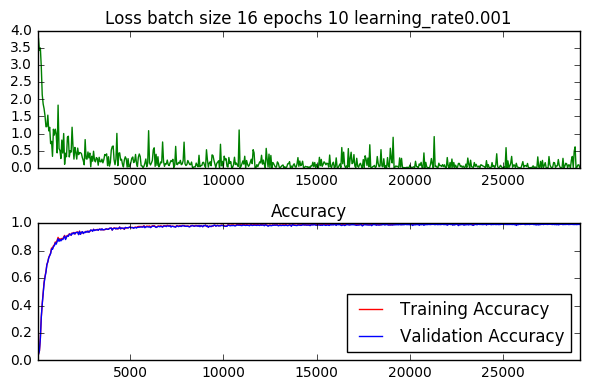

Validation accuracy at 0.9924536943435669
[0.99245369]
Test accuracy at 0.9346007108688354


In [8]:
### Train your model here.
### Feel free to use as many code cells as needed.
from tqdm import tqdm
import math

results = []
#jobs = [(1,16),(1,32),(1,64),(2,16),(2,32),(2,64),(3,16),(3,32),(3,64)]
jobs = [(10,16, 0.001, 0.15)]

session = None
for job in jobs:
  (n_epoch,batch_size, learning_rate,dropout) = job
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)    
  init = tf.global_variables_initializer()

  valid_feed_dict={images: X_valid_g1, labels: y_valid_1, keep_prob:1}
  test_feed_dict={images: X_test_g, labels: y_test, keep_prob:1}


#  (n_epoch,batch_size) = job
  test_accuracy = 0.0
  validation_accuracy = 0.0
  last_validation_accuracy = 0.0
  log_batch_step = 50
  batches = []
  loss_batch = []
  train_acc_batch = []
  valid_acc_batch = []

  session = tf.Session()
  session.run(init)
  batch_count = int(math.ceil(X_train_g1.shape[0]/batch_size))

  for epoch in range(n_epoch):
        
      # Progress bar
      batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{} '.format(epoch+1, n_epoch, loss), unit=' batches')
        
      # The training cycle
      for batch_i in batches_pbar:
          # Get a batch of training features and labels
          batch_start = batch_i*batch_size
          batch_images = X_train_g1[batch_start:batch_start + batch_size]
          batch_labels = y_train_1[batch_start:batch_start + batch_size]

          # Run optimizer and get loss
          _, l = session.run(
                [optimizer, loss],
                feed_dict={images: batch_images, labels: batch_labels, keep_prob: (1-dropout)})

          # Log every 50 batches
          if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
        
                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
        

      # Check accuracy against Validation data
      validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
      if last_validation_accuracy > validation_accuracy:
        print("early termination, stop at epoch ",epoch)
        break
      last_validation_accuracy = validation_accuracy 
        
        
  pred = []
  results.append(validation_accuracy)
  test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)
  pred = session.run(is_correct_prediction, feed_dict=test_feed_dict)
  print("predicted:",pred)


  loss_plot = plt.subplot(211)
  loss_plot.set_title("Loss batch size {0} epochs {1} learning_rate{2}".format(batch_size, n_epoch, learning_rate))
  loss_plot.plot(batches, loss_batch, 'g')
  loss_plot.set_xlim([batches[0], batches[-1]])
  acc_plot = plt.subplot(212)
  acc_plot.set_title('Accuracy')
  acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
  acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
  acc_plot.set_ylim([0, 1.0])
  acc_plot.set_xlim([batches[0], batches[-1]])
  acc_plot.legend(loc=4)
  plt.tight_layout()
  plt.show()

  print('Validation accuracy at {}'.format(validation_accuracy))
  print(results)
  print('Test accuracy at {}'.format(test_accuracy))

 

[16  1 38 ...,  6  7 10]
(12630,)
(12630,)


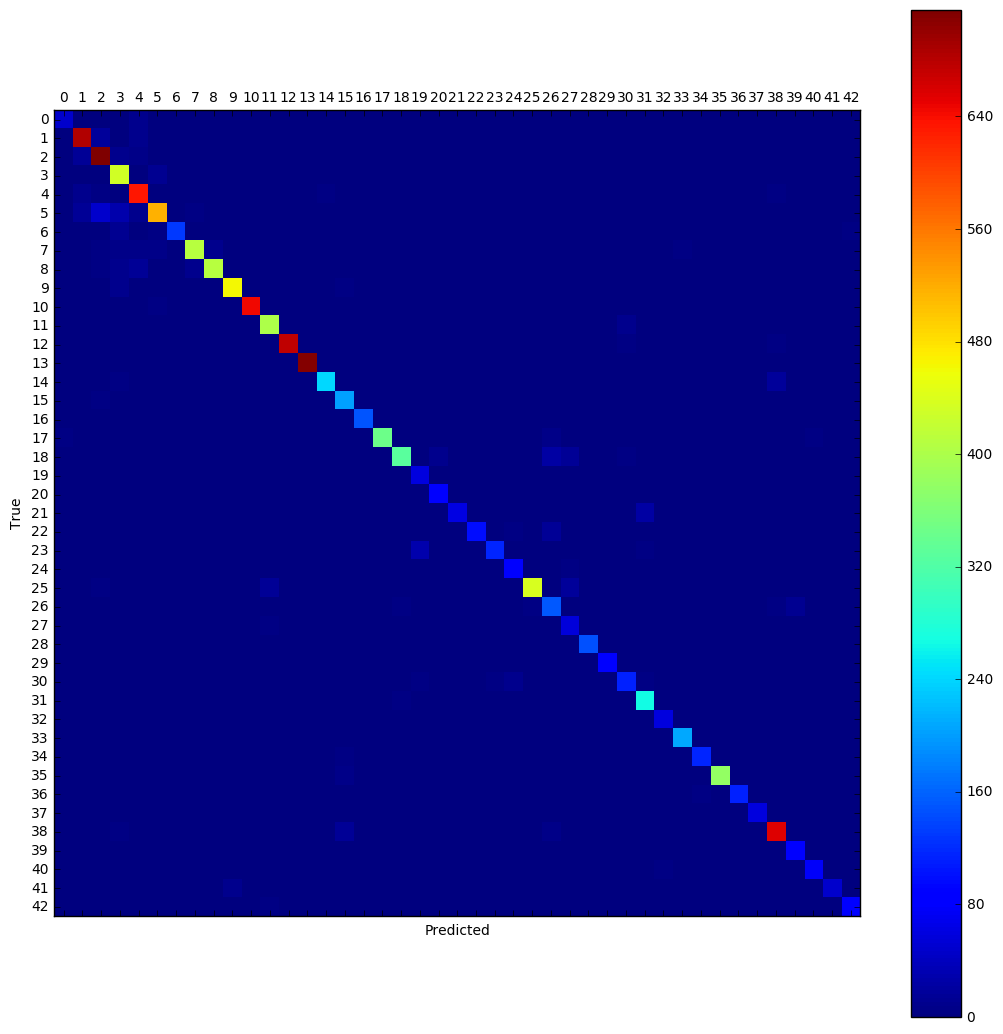

Animation 12630: 100%|██████████| 100/100 [00:00<00:00, 864.73images/s]


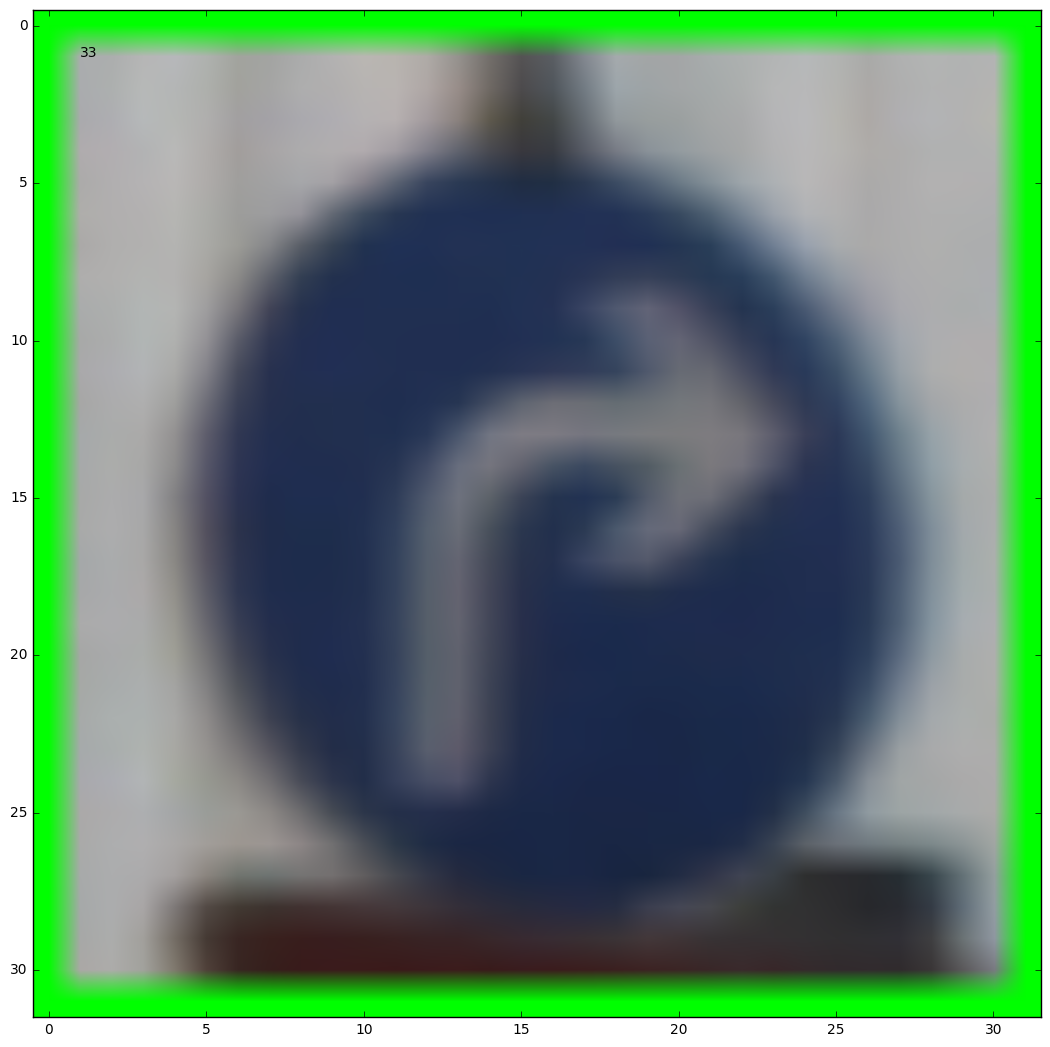

In [9]:
print(y_test_orig)

from moviepy.editor import ImageSequenceClip
from matplotlib import animation 
from sklearn.metrics import confusion_matrix
from pylab import rcParams

def plot_confusion_matrix(test,pred):
    cm = confusion_matrix(y_true=test,
                          y_pred=pred)

    plt.figure(figsize=(40,40))
    rcParams['figure.figsize'] = 13, 13
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

pred_cls = tf.argmax(prediction,1)    
pred_cls = pred_cls.eval(feed_dict=test_feed_dict,session=session)
test_cls = np.argmax(y_test,1)
plot_confusion_matrix(test_cls,pred_cls)    
    

def color_frame(image, color):
  image[0:32,0] = color
  image[0:32,31] = color
  image[0,0:32] = color
  image[31,0:32] = color
  return image

#create a video of the test images showing a green frame, when prediction is correct and red, when incorrect
def process_images(pred,frames,labels):
  list = []

  # Progress bar
  pbar = tqdm(range(100), desc='Animation {0}'.format(frames.shape[0]), unit='images')
  for i in pbar:
        
    fig = plt.figure("Animation")
    ax = fig.add_subplot(111)
    if pred[i]:
      frame =  ax.imshow(color_frame(frames[i],(0 ,255,0)))   
    else:
      frame =  ax.imshow(color_frame(frames[i],(255,0,0)))   
    
    t = ax.annotate(y_test_orig[i],(1,1)) # add text        
    list.append([frame,t])
    
  Writer = animation.writers['ffmpeg']
  writer = Writer(fps=5, metadata=dict(artist='traffic signs'))
    
  anim = animation.ArtistAnimation(fig, list, interval=50, blit=True, repeat_delay=3000)
  anim.save('anim.mp4', writer=writer)
  plt.show()  
  return list

list = process_images(pred,X_test,y_test)


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I chosed AdamOptimizer as its commonly known to be very efficient. Previous test using an GraidentOptimizer confirmed that.

First I compared the train and validation accuray for a range of batch sizes (16 to 512)
I choosed batch size 16 because its performance much better then larger batch sizes.

Than I run the train and and validation for combinations of batch_size and number of epochs 
to verify the choosen batch_size performace well during more epochs

In the next phase, I indroduced an early termination if the validation accuracity increases between epochs. Tests showed that the validation accuracy does increase not significantly after the 6 and 10 epoch. 

Comparing the test accuracy for traings based on the same model but different epoch sizes, I recognized that the test accuracy follows the validation accuracy. So the validiation of the model is a good criteria for training success. Best result has been 4 epoch bath size 16, learnig rate 0.001. 
(validation accuracy 0.992, Test accuracy at 0.935)

In the next step, I changed the learning rate to investigate, how the validation accuracy develops. I trained using rates between 0.0001 and 0.2. Best results on the test set I achieved at the learning rate 0.001.

Overall best result has been accuracy of 98% on the validation set and 91.3% on the test set. This drop of 6.7% could indicate overfitting.


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
To avoid overfitting, I introduced two dropout layer after the first two max pooling starting with a drop rate of 5%
the results have slightly improved. Best dropout rate has been 10%. test accuracy increased to 93.5%, validation accuracy remained at 99%.

Further improvement could be gained if I would use several versions of trained models with reshuffeled train/ validation sets based on different random seeds and weight the predictions of these models.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

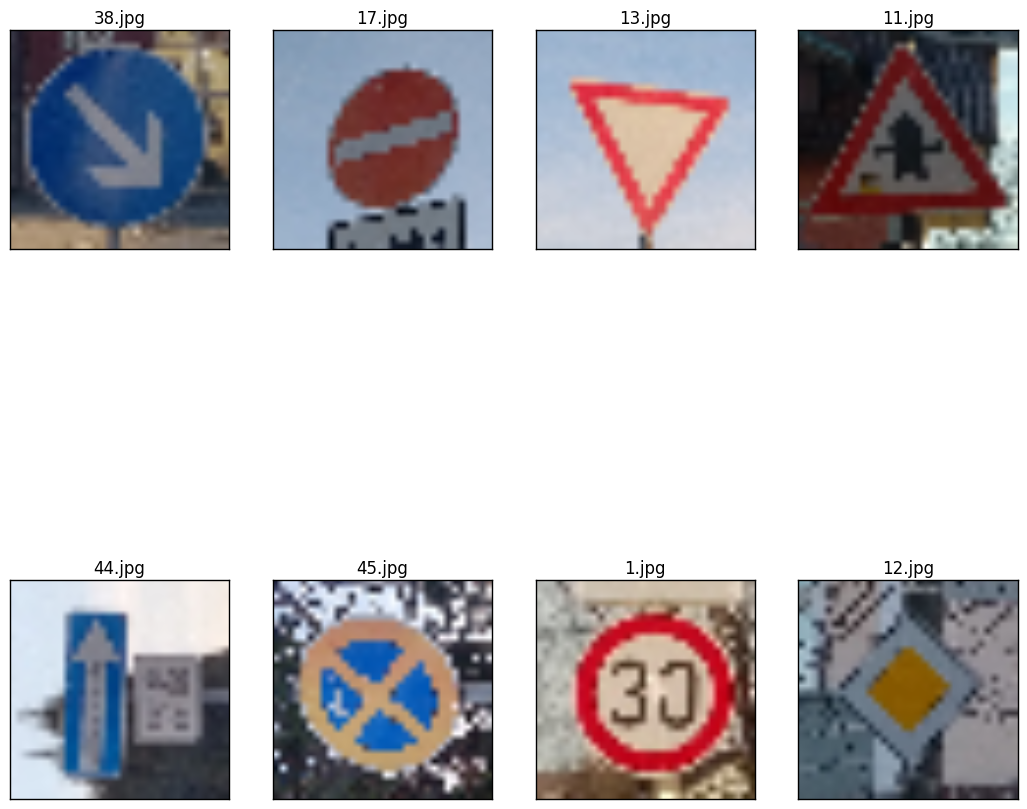

['38', '17', '13', '11', '44', '45', '1', '12']


In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import os
#loop over the test pictures
X_test_g2 = []
y_test_2 = []
fig = plt.figure()
i=1
gs = gridspec.GridSpec(2, 4)
col=0
row=0
for item in os.listdir("test_images/"):
  path_to_image = os.path.join("test_images",item)
  image = mpimg.imread(path_to_image)    
  image = cv2.resize(image,(32,32))
  a = plt.subplot(gs[row, col])
  a.imshow(image)
  a.get_xaxis().set_visible(False)
  a.get_yaxis().set_visible(False)
  fig.add_subplot(a)
  X_test_g2.append(grayscale(image))
  y = item[0:-4]
  y_test_2.append(y)
  a.set_title(item)
  col += 1                   
  if col == 4:
    col = 0
    row += 1
plt.show()
print(y_test_2)
X_test_g2 = np.array(X_test_g2)
X_test_g2 = np.reshape(X_test_g2,(X_test_g2.shape[0],X_test_g2.shape[1],X_test_g2.shape[2],1))
y_test_2 = encoder.transform(y_test_2).astype(np.float32)



### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
I see two main issues to make classiciation difficult:
1. the image is representing an unknown class. I choosed two and classified them as 44 and 45.
2. the pictures are taken from a car from closer distance, so they image of the the signs contain perspective transformations

In [16]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
test_feed_dict={images: X_test_g2, labels: y_test_2, keep_prob:1}
test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)
pred = session.run(prediction, feed_dict=test_feed_dict)


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

the 1., the 7. and 8. predictions are correct
the 4. is wrongly recognized as 27, which is very similar. This is an error that can be expected
the 2. and 3. are not recognized which is disappointing. The reason could be the stron transformation of the perspective in both images
the 5. and 6. are wrong, which is correct as they represent unknown classes


In [17]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
print("predicted:",pred)



predicted: [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
the model certain about its predictions

In [18]:
print(session.run(tf.nn.top_k(prediction, 2), feed_dict=test_feed_dict))


TopKV2(values=array([[  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   7.26940643e-12],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[38,  0],
       [17,  0],
       [13,  0],
       [11,  0],
       [11, 27],
       [39,  0],
       [ 1,  0],
       [12,  0]], dtype=int32))


### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.